In [53]:
! pip install -q pytorch-lightning
! pip install -q bs4
! pip install -q transformers
! pip install ipywidgets
! pip install pandas
! pip install sklearn
! pip install seaborn

In [54]:
# https://github.com/pnageshkar/NLP/blob/master/Medium/Multi_label_Classification_BERT_Lightning.ipynb
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [55]:
# load the questions data set
df_questionsA=pd.read_csv("U:/computer/Python BERT/CFA data/NAXION_Q5_top13text_for_BERT.csv", encoding='iso-8859-1')
#load the tags dataset
#df_tagsA=pd.read_csv("U:\computer\Python BERT\Kaggle tag data\Tags.csv", encoding='iso-8859-1')

df_tagsA=pd.read_csv("U:/computer/Python BERT/CFA data/NAXION_Q5_top13tags_for_BERT.csv", encoding='iso-8859-1')

In [56]:
df_questionsA.shape

(1378, 3)

In [57]:
df_tagsA.shape

(1975, 3)

In [58]:
df_questionsA.head()

,Unnamed: 0,Id,Body
0,1,1,Adding headcount to assist with volume of work
1,3,3,Understanding that we need to focus on improvi...
2,8,8,Which systems to use - Seems like we have mult...
3,9,9,The program we use to pick is very limited in ...
4,10,10,Communication within the business - CFA Supply...


In [59]:
df_questionsA[600:610]

,Unnamed: 0,Id,Body
600,1315,1315,"It does feel like many times, out of way too m..."
601,1316,1316,How we work together. Lack of process creates ...
602,1318,1318,Strategically how CFA Staff is used to stand u...
603,1319,1319,It is difficult for me to think of improvement...
604,1321,1321,Hiring talent that may not want to relocate or...
605,1326,1326,How much resourcing to provide for Internation...
606,1330,1330,Speed of decision making.
607,1331,1331,CFA tends to hesitate too much when making dec...
608,1332,1332,"While we generally hire high-quality people, I..."
609,1333,1333,More detailed direction and action plan on dep...


In [60]:
df_tagsA.head()

,Unnamed: 0,Id,Tag
0,1,1,2
1,2,3,4
2,3,3,54
3,4,8,6
4,5,9,53


In [61]:
#take a subset of the data so the code runs faster
#df_questions=df_questionsA[1:50000]
#df_tags=df_tagsA[1:50000]
df_questions=df_questionsA
df_tags=df_tagsA


In [62]:
#Pre process the data

def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [63]:
# clean the text in Body column
df_questions['Clean_Body'] = df_questions['Body'].apply(pre_process)
#df_all['Clean_Body'] = df_all['Body'].apply(pre_process)
#df_questions['Clean_Body'] = df_questions['Body'].str.lower()

C:\Users\elainez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [64]:
#possiblity 1
#df_all['Clean_Body'] = re.sub("[^a-zA-Z]", " ", df_all['Clean_Body'])
df_questions.head()

,Unnamed: 0,Id,Body,Clean_Body
0,1,1,Adding headcount to assist with volume of work,adding headcount to assist with volume of work
1,3,3,Understanding that we need to focus on improvi...,understanding that we need to focus on improvi...
2,8,8,Which systems to use - Seems like we have mult...,which systems to use seems like we have multip...
3,9,9,The program we use to pick is very limited in ...,the program we use to pick is very limited in ...
4,10,10,Communication within the business - CFA Supply...,communication within the business cfa supply c...


In [65]:
df_questions['Body'][1]

'Understanding that we need to focus on improving our current operations and streamlining it while we thinking about growth and the future'

In [66]:
df_questions['Clean_Body'][1]

'understanding that we need to focus on improving our current operations and streamlining it while we thinking about growth and the future'

In [67]:
# count of unique tags
len(df_tags['Tag'].unique())

13

In [68]:
df_tags['Tag'].value_counts()[0:20]

53    300
13    275
2     221
54    157
70    157
52    152
3     135
6     114
4     102
12    101
7      91
8      85
69     85
Name: Tag, dtype: int64

In [69]:
df_tags['Tag'].value_counts()

53    300
13    275
2     221
54    157
70    157
52    152
3     135
6     114
4     102
12    101
7      91
8      85
69     85
Name: Tag, dtype: int64

In [70]:
df_tags.head()

,Unnamed: 0,Id,Tag
0,1,1,2
1,2,3,4
2,3,3,54
3,4,8,6
4,5,9,53


In [71]:
# remove "-" from the tags
#df_tags['Tag']= df_tags['Tag'].apply(lambda x:re.sub("-"," ",x))

In [72]:
# Consider only Top 10 tags - want to keep a smaller dataset
#top_tags = df_tags['Tag'].value_counts().keys()[0:10]
top_tags = df_tags['Tag'].value_counts().keys()[0:15]
top_tags

Int64Index([53, 13, 2, 54, 70, 52, 3, 6, 4, 12, 7, 8, 69], dtype='int64')

In [73]:
# First group tags Id wise
df_tags = df_tags.groupby('Id').apply(lambda x:x['Tag'].values).reset_index(name='tags')
df_tags.head()

,Id,tags
0,1,[2]
1,3,"[4, 54]"
2,8,[6]
3,9,[53]
4,10,"[8, 54]"


In [74]:
# merge tags and questions datasets
df = pd.merge(df_questions,df_tags,how='inner',on='Id')

In [75]:
df.head()

,Unnamed: 0,Id,Body,Clean_Body,tags
0,1,1,Adding headcount to assist with volume of work,adding headcount to assist with volume of work,[2]
1,3,3,Understanding that we need to focus on improvi...,understanding that we need to focus on improvi...,"[4, 54]"
2,8,8,Which systems to use - Seems like we have mult...,which systems to use seems like we have multip...,[6]
3,9,9,The program we use to pick is very limited in ...,the program we use to pick is very limited in ...,[53]
4,10,10,Communication within the business - CFA Supply...,communication within the business cfa supply c...,"[8, 54]"


In [76]:
df.shape

(1378, 5)

In [77]:
df.to_csv("U:/computer/Python BERT/CFA data/outQ5top13_cleanbody3.csv")

In [78]:
# Retain only the columns we will use for training the model - Tags will be the label
df = df[['Clean_Body','tags']]
df.head()

,Clean_Body,tags
0,adding headcount to assist with volume of work,[2]
1,understanding that we need to focus on improvi...,"[4, 54]"
2,which systems to use seems like we have multip...,[6]
3,the program we use to pick is very limited in ...,[53]
4,communication within the business cfa supply c...,"[8, 54]"


In [79]:
df.shape

(1378, 2)

In [80]:
#df.to_csv("clean_question_tag.csv")

In [81]:
# Filter out records ( values in clean_body and tags) that have atleast one of the top tags

x=[] # To store the filtered clean_body values
y=[] # to store the corresponding tags
# Convert to list data type
lst_top_tags = list(top_tags)

for i in range(len(df['tags'])):
    temp=[]
    for tag in df['tags'][i]:
        if tag in lst_top_tags:
            temp.append(tag)

    if(len(temp)>0):
        x.append(df['Clean_Body'][i])
        y.append(temp)

In [82]:
# number of records that will be used for training and testing
len(x)

1378

In [83]:
xx=x[0]
xx.split()

['adding', 'headcount', 'to', 'assist', 'with', 'volume', 'of', 'work']

In [84]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(1378, 13)

In [85]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[1 0 0 0 0 0 0 0 0 0 0 0 0]
[(2,)]
[2 3 4 6 7 8 12 13 52 53 54 69 70]


In [86]:
len(x)

1378

In [87]:
x[608]

'while we generally hire high quality people i ve noticed a trend of waning stewardship in newer staff when it comes to technology there s an attitude of i want it and chick fil a has the money where i feel like five years ago there was more of an attitude of saying do i really need this all of that to say i feel like we need to be instilling stewardship into newer hires and reminding others of what stewardship really looks like'

In [88]:
xx=x[608]
xx.split()

['while',
 'we',
 'generally',
 'hire',
 'high',
 'quality',
 'people',
 'i',
 've',
 'noticed',
 'a',
 'trend',
 'of',
 'waning',
 'stewardship',
 'in',
 'newer',
 'staff',
 'when',
 'it',
 'comes',
 'to',
 'technology',
 'there',
 's',
 'an',
 'attitude',
 'of',
 'i',
 'want',
 'it',
 'and',
 'chick',
 'fil',
 'a',
 'has',
 'the',
 'money',
 'where',
 'i',
 'feel',
 'like',
 'five',
 'years',
 'ago',
 'there',
 'was',
 'more',
 'of',
 'an',
 'attitude',
 'of',
 'saying',
 'do',
 'i',
 'really',
 'need',
 'this',
 'all',
 'of',
 'that',
 'to',
 'say',
 'i',
 'feel',
 'like',
 'we',
 'need',
 'to',
 'be',
 'instilling',
 'stewardship',
 'into',
 'newer',
 'hires',
 'and',
 'reminding',
 'others',
 'of',
 'what',
 'stewardship',
 'really',
 'looks',
 'like']

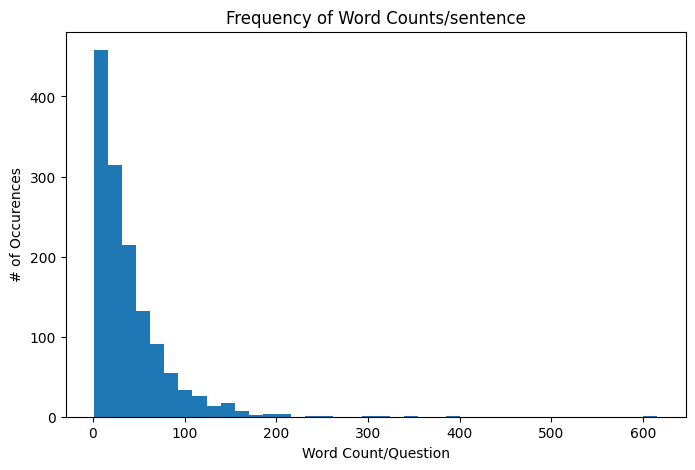

In [89]:
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [90]:
#Split into train, validate and test
#from sklearn.model_selection import train_test_split
# First Split for Train and Test
#x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
#x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [91]:
#Use all data for training
#Use all data for scoring
from sklearn.model_selection import train_test_split
x_train=x
x_test=x
y_train=yt
y_test=yt
#x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=RANDOM_SEED,shuffle=True)
x_tr=x_train
y_tr=y_train 
x_val=x_train 
y_val=y_train

In [92]:
len(x_tr) ,len(x_val), len(x_test)

(1378, 1378, 1378)

In [93]:
#prepare the dataset and datamodule
#First create QTagDataset class based on the Dataset class,that readies the text in a format needed for the BERT Model
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }

In [94]:
#Since we are using Pytorch Lightning for Model training - we will setup the QTagDataModule class that is derived from the LightningDataModuleclass QTagDataModule (pl.LightningDataModule):
    
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=200):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=0)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [95]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" # we will use the BERT base model(the smaller one)
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [96]:
max_word_cnt = 300
quest_cnt = 0

# For every sentence...
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors


# Question having word count > 300: is  5


In [97]:
# Initialize the parameters that will be use for training
N_EPOCHS = 12
BATCH_SIZE = 32
MAX_LEN = 300
LR = 2e-05

In [98]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

In [99]:
#Train the Model
#Setup the Multi-label Classifier Model - dervived from LightningModule , similar to nn.module of PyTorch
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=13, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch//3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]
    

In [100]:
# Instantiate the classifier model
steps_per_epoch = len(x_tr)//BATCH_SIZE
model = QTagClassifier(n_classes=13, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [102]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , callbacks=[checkpoint_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [103]:
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [104]:
# Train the Classifier Model
trainer.fit(model, QTdata_module)

C:\Users\elainez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 10.0 K
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.281   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\elainez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\elainez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\elainez\AppDa

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=12` reached.


In [105]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

C:\Users\elainez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.17563983798027039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17563983798027039}]

In [106]:
# Visualize the logs using tensorboard.
#%load_ext tensorboard
#%tensorboard --logdir lightning_logs/

In [107]:
#Evaluate Model Performance on Test Set
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

'u:\\computer\\Python BERT\\CFA data\\lightning_logs\\version_18\\checkpoints\\QTag-epoch=11-val_loss=0.18.ckpt'

In [108]:
len(y_test), len(x_test)

(1378, 1378)

In [109]:
#setup test dataset for BERT
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [110]:
#pred_data[0]

In [111]:
#len(pred_dataloader.dataset)

In [112]:
#Prediction on test set
flat_pred_outs = 0
flat_true_labels = 0

In [113]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [114]:
pred_outs[0][0]

array([0.8481674 , 0.1393871 , 0.08275281, 0.05909206, 0.07500816,
       0.03847723, 0.07170097, 0.08627117, 0.08286046, 0.10536888,
       0.09845867, 0.07699985, 0.08807137], dtype=float32)

In [115]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [116]:
flat_pred_outs.shape , flat_true_labels.shape

((1378, 13), (1378, 13))

In [117]:
#Predictions of Tags in Test set
#The predictions are in terms of logits (probabilities for each of the 16 tags). Hence we need to have a threshold value to convert these probabilities to 0 or 1.

#Let's specify a set of candidate threshold values. We will select the threshold value that performs the best for the test set.

#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [118]:
#Let's define a function that takes a threshold value and uses it to convert probabilities into 1 or 0.

# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred
    

In [119]:
flat_pred_outs[3]

array([0.11204794, 0.04480898, 0.06299059, 0.10928649, 0.04194148,
       0.04757924, 0.053918  , 0.15929148, 0.03514407, 0.46914038,
       0.06998488, 0.04050256, 0.02892958], dtype=float32)

In [120]:
flat_true_labels[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [121]:
flat_pred_outs[20]

array([0.8598196 , 0.1379045 , 0.08012619, 0.05150995, 0.07986446,
       0.04617438, 0.07297174, 0.05847909, 0.11331302, 0.11651993,
       0.08277801, 0.08327325, 0.09599952], dtype=float32)

In [122]:
flat_true_labels[20]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [123]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [124]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')

Optimal Threshold Value = 0.4


In [125]:
#y_true = flat_true_labels.ravel() 

In [126]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [127]:
y_true

array([1, 0, 0, ..., 0, 0, 0])

In [128]:
pd.Series(y_pred).value_counts()

0    16656
1     1258
dtype: int64

In [129]:
#flat_true_labels

In [130]:
#Performance Score Evaluation

#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,opt_thresh)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [131]:
y_true

array([1, 0, 0, ..., 0, 0, 0])

In [132]:
y_true.shape

(17914,)

In [133]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [134]:
y_pred.shape

(17914,)

In [135]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     15939
           1       0.96      0.72      0.82      1975

    accuracy                           0.97     17914
   macro avg       0.96      0.86      0.90     17914
weighted avg       0.97      0.97      0.96     17914



In [136]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})

In [137]:
len(x_test)

1378

In [138]:
len(y_act)

1378

In [139]:
len(y_pred)

1378

In [140]:
x_test

['adding headcount to assist with volume of work',
 'understanding that we need to focus on improving our current operations and streamlining it while we thinking about growth and the future',
 'which systems to use seems like we have multiply systems that perform the same function',
 'the program we use to pick is very limited in its abilities and is causing productivity losses during the picking process such as causing unneeded congestion and not allowing team members to do tasks that would help keep inventory in line and maintain output',
 'communication within the business cfa supply can do a better job of communicating changes that are being made and that are on the horizon within the business this can be a struggle as we grow but communication is vitally important',
 'ey resourcing and length on projects right now there are consultants assigned to nashville mdc project plan smartsheet does this need this much staffing better rolloff plan of ey consultants and then staff filling t

In [141]:
df.shape

(1378, 3)

In [142]:
df.sample(10)

,Body,Actual Tags,Predicted Tags
597,how we account for headcount and resources the...,"(2,)","(2,)"
700,we need to move quicker with technology advanc...,"(6, 13)","(6, 13)"
1222,the cwt platform is not always functional reli...,"(53,)","(53,)"
1145,we are growing really fast so it takes longer ...,"(13, 54)","(13, 54)"
602,strategically how cfa staff is used to stand u...,"(12, 54)","(54,)"
1078,when to engage contractors i know engagement o...,"(2, 54)","(2,)"
65,i wish that administrators who desired to purs...,"(3,)","(3,)"
745,headcount and people leader decisions,"(2, 70)","(2,)"
478,acknowledging distinction between staff roles ...,"(53,)","(53,)"
67,budget tracking decisions the new system makes...,"(6,)",()


In [143]:
df.to_csv("U:/computer/Python BERT/CFA data/outQ5top13_3.csv")

In [144]:
#flat_true_labels.shape

In [145]:
#np.array(y_pred_labels).shape

In [146]:
#y_temp = mlb.inverse_transform(flat_true_labels)
#y_temp

In [147]:
#Inference
# load a model along with its weights, biases and hyperparameters
QTmodel = QTagClassifier.load_from_checkpoint(model_path)
QTmodel.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QTagClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [148]:
#Function to Predict Tags from a Question
def predict(question):
    text_enc = Bert_tokenizer.encode_plus(
            question,
            None,
            add_special_tokens=True,
            max_length= MAX_LEN,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True,
            truncation=True,
            return_tensors = 'pt'      
    )
    outputs = QTmodel(text_enc['input_ids'], text_enc['attention_mask'])
    pred_out = outputs[0].detach().numpy()
    #print(f'Outputs = {outputs}')
    #print(f'Type = {type(outputs)}')
    #print(f'Pred Outputs = {pred_out}')
    #print(f'Type = {type(pred_out)}')
    #preds = np.round(pred_out)
    preds = [(pred > opt_thresh) for pred in pred_out ]
    #pred_list = [ round(pred) for pred in pred_logits ]
    preds = np.asarray(preds)
    #print(f'Predictions = {preds}')
    #print(f'Type = {type(preds)}')
    #print(mlb.classes_)
    new_preds = preds.reshape(1,-1).astype(int)
    #print(new_preds)
    pred_tags = mlb.inverse_transform(new_preds)
    #print(mlb.inverse_transform(np.array(new_preds)))
    return pred_tags 

In [149]:
#Try out the Model - Ask a question

# Your question stored in the question variable
question = "based on the following relationship between matthew s correlation coefficient mcc and chi square mcc is the pearson product moment correlation coefficient is it possible to conclude that by having imbalanced binary classification problem n and p df following mcc is significant mcc sqrt which is mcc when comparing two algorithms a b with trials of times if mean mcc a mcc a mean mcc b mcc b then a significantly outperforms b thanks in advance edit roc curves provide an overly optimistic view of the performance for imbalanced binary classification regarding threshold i m not a big fan of not using it as finally one have to decide for a threshold and quite frankly that person has no more information than me to decide upon hence providing pr or roc curves are just for the sake of circumventing the problem for publishing"

# Call the predict function to predict the associated Tags
tags = predict(question)
if not tags[0]:
    print('This Question can not be associated with any known tag - Please review to see if a new tag is required ')
else:
    print(f'Following Tags are associated : \n {tags}')

This Question can not be associated with any known tag - Please review to see if a new tag is required 


In [ ]:
#save the model
torch.save(QTmodel.state_dict(), 'U:/computer/Python BERT/CFA data/BERT_saved_model/BERT_Q5_top13.pth')
#torch.save(model.state_dict(), 'U:/computer/Python BERT/CFA data/BERT_saved_model/BERT_Q5a.pth')
#saved_model = torch.load('U:/computer/Python BERT/CFA data/BERT_saved_model')

#model=QTagClassifier()
#model.load_state_dict(torch.load('U:/computer/Python BERT/CFA data/BERT_saved_model/BERT_Q5.pth'))

#
#saving model
#https://stackoverflow.com/questions/59340061/saving-a-fine-tuned-bert-model
#https://mccormickml.com/2019/07/22/BERT-fine-tuning/#advantages-of-fine-tuning